## ISLR (Chapter 8) - Tree-based Methods - 11/01/21

Often times in Python (similar to R) the best way to sync the packages that one needs is to create a <font color='purple'>**new installation**</font>. On Mac and using Anaconda, the steps are

1) Create a **new environment** with the version of Python (3.8 is the latest at the moment) and the main packages you want, e.g.

<font color='darkpink'> conda create -n DSML python=3.8 numpy pandas scipy scikit-learn statsmodels matplotlib seaborn jupyterlab python-graphviz </font>

2) Then **activate** the environment DSML **before** starting your Jupyter Lab/Notebook 

<font color='darkpink'> conda activate DSML </font>

or before you need to install an additional package as in this example

<font color='darkpink'> conda install -c anaconda pydot </font>

3) When you are done deactivate the environment - only one is active at any point, so Anacond knows what to do:

<font color='darkpink'> conda deactivate </font>

- [8.1.1 Regression Trees](#8.1.1-Regression-Trees)
- [8.1.2 Classification Trees](#8.1.2-Classification-Trees)
- [Lab: 8.3.1 Fitting Classification Trees](#8.3.1-Fitting-Classification-Trees)
- [Lab: 8.3.2 Fitting Regression Trees](#8.3.2-Fitting-Regression-Trees)


In [1]:
from sklearn import __version__
__version__

'1.0.1'

In [2]:
%load_ext autoreload
%autoreload 2
import sys

In [3]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Tree plotting
import pydot
from IPython.display import Image
import graphviz 
#from sklearn.externals.six import StringIO  
from io import StringIO  

# Model selection
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

# Trees
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz

%matplotlib inline
plt.style.use('seaborn-white')

<font color='darkpink'>**Define some functions used for tree visualization.**</font>

In [4]:
#=== This function creates images of tree models using 'pydot' & 'export_graphviz'
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return (graph)

#=== Prints binary rules for a decision tree
# from: # https://scikit-learn.org/dev/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py
def tree_structure(clf):

    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack` so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has {n} nodes and has "
          "the following tree structure:\n".format(n=n_nodes))
    for i in range(n_nodes):
        if is_leaves[i]:
            print("{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i))
        else:
            print("{space}node={node} is a split node: "
                  "go to node {left} if X[:, {feature}] <= {threshold} "
                  "else to node {right}.".format(
                      space=node_depth[i] * "\t",
                      node=i,
                      left=children_left[i],
                      feature=feature[i],
                      threshold=threshold[i],
                      right=children_right[i]))

### 8.1.1 Regression Trees

The Baseball related dataset 'Hitters' from package 'ISLR' was exported (in R) to a csv file. Let's load it:

In [5]:
df_hit = pd.read_csv('/Users/daniel421/Desktop/STAT_724/ISLR_data/Hitters.csv').dropna()
#df.info()
df_hit.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N
5,-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,750.0,A


Let's keep only 2 features - Years and Hits.

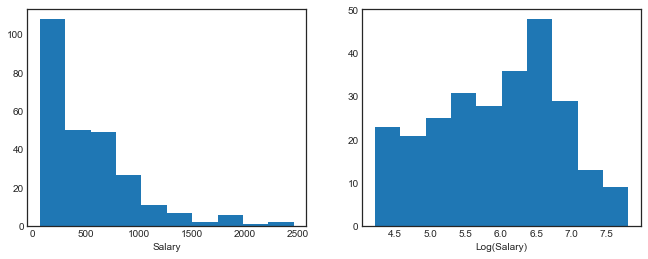

In [6]:
X = df_hit[['Years', 'Hits']].values
y = np.log(df_hit.Salary.values)     # Log-transform

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.hist(df_hit.Salary.values)
ax1.set_xlabel('Salary')
ax2.hist(y)
ax2.set_xlabel('Log(Salary)');

In [7]:
# X[:4,]

In [8]:
# Tree with 3 leaf nodes. Note that we fix the random state (seed) for reproducibility.

regr = DecisionTreeRegressor(max_leaf_nodes=3, random_state=0)
regr.fit(X, y) #when executed, the regr object is a model

DecisionTreeRegressor(max_leaf_nodes=3, random_state=0)

[Text(133.92000000000002, 181.2, 'X[0] <= 4.5\nsquared_error = 0.788\nsamples = 263\nvalue = 5.927'),
 Text(66.96000000000001, 108.72, 'squared_error = 0.471\nsamples = 90\nvalue = 5.107'),
 Text(200.88000000000002, 108.72, 'X[1] <= 117.5\nsquared_error = 0.42\nsamples = 173\nvalue = 6.354'),
 Text(133.92000000000002, 36.23999999999998, 'squared_error = 0.312\nsamples = 90\nvalue = 5.998'),
 Text(267.84000000000003, 36.23999999999998, 'squared_error = 0.252\nsamples = 83\nvalue = 6.74')]

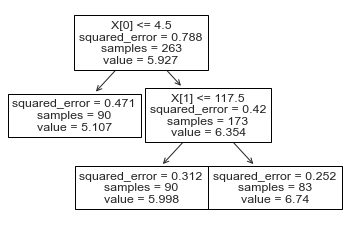

In [9]:
# Simple plot
import sklearn.tree as tree
tree.plot_tree(regr) 

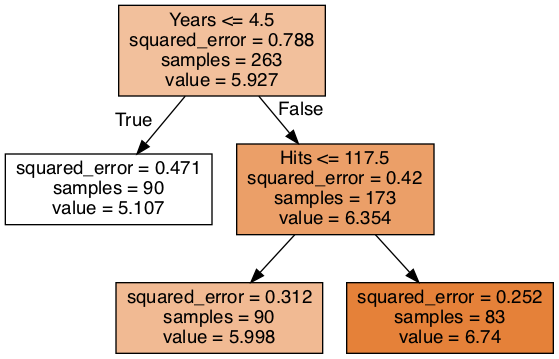

In [10]:
#Draw graph using the finction defined in the beginning of the notebook
graph, = print_tree(regr, features = ['Years', 'Hits']) 
Image(graph.create_png())

In [ ]:
?graph.create_png #reinstall pytdot

In [ ]:
# Understand the tree structure

tree_structure(regr)

In [ ]:
# Plot data partition into 3 regions

df_hit.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(7,6))
plt.xlim(0,25)
plt.ylim(ymin=-5)
plt.xticks([1, 4.5, 24])
plt.yticks([1, 117.5, 238])
plt.vlines(4.5, ymin=-5, ymax=250)
plt.hlines(117.5, xmin=4.5, xmax=25)
plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
plt.annotate('R2', xy=(11,60), fontsize='xx-large')
plt.annotate('R3', xy=(11,170), fontsize='xx-large');

### Pruning

Somewhat different approach to prunning is supported in **scikit-learn**. See implementation <A href='https://scikit-learn.org/dev/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py'>details</A>. 

Random Forests (RF) and other Ensemble methods, where **tree prunning** is not used, have better predictive qualities than a single pruned tree, so mastering the prunning technique is **not a must**. 

In [ ]:
# Split data to train and test and create a sequence of trees corresponding to sequence of values of 'alpha', the cost-complexity parameter (ccp):
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

regr2 = DecisionTreeRegressor(random_state=0)
path = regr2.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
# path.impurities?

**(a) "Impurity"**:  In the following plot, the maximum effective alpha value is removed, because it is the trivial tree with only one node. In the case of a regression tree, "impurity" is the MSE.

https://scikit-learn.org/dev/modules/tree.html#minimal-cost-complexity-pruning

The cost complexity measure for a tree $T$ is defined as $R_\alpha (T) = R(T) + \alpha |\tilde{T}|$, where $|\tilde{T}|$ is the number of terminal nodes in $T$.

The cost complexity measure of a single node is $R_\alpha (t) = R(t) + \alpha$. The branch, $T_t$, is defined to be a tree where node $t$ is its root. In general, the impurity of a node is greater than the sum of impurities of its terminal nodes, $R(T_t)<R(t)$. However, the cost complexity measure of a node, $t$, and its branch, $T_t$, can be equal depending on $\alpha$. The <font color='blue'>**effective $\alpha$**</font> of a node is defined to be the value where they are equal, $R_\alpha (T_t) = R_\alpha (t)$ or $\alpha_{eff} = \frac{R(t)-R(T_t)}{|T|-1}$. 

A non-terminal node with the smallest value of $\alpha_{eff}$ is the weakest link and will be pruned. This process stops when the pruned tree’s minimal $\alpha_{eff}$ is greater than the ccp_alpha parameter.

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Next, we train a decision tree using the effective alphas. The last value
in ``ccp_alphas`` is the alpha value that prunes the whole tree,
leaving the tree, ``clfs[-1]``, with one node.



In [ ]:
regs = []
for ccp_alpha in ccp_alphas:
    reg = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    reg.fit(X_train, y_train)
    regs.append(reg)

print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(regs[-1].tree_.node_count, ccp_alphas[-1]))

**(b) Depth and number of nodes**: 
Here we show that the number of nodes and tree depth decreases as alpha increases.

In [ ]:
regs = regs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [reg.tree_.node_count for reg in regs]
depth = [reg.tree_.max_depth for reg in regs]

plt.style.use('ggplot')
# ax = plt.subplots(2, 1)
# figure = plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(2, 1)

ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")

ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

(c) Now, demonstrate **overfitting** by plotting the accuracy vs. alpha of trees built on train and test sets, respectively:

In [ ]:
train_scores = [reg.score(X_train, y_train) for reg in regs]
test_scores = [reg.score(X_test, y_test) for reg in regs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_xlim((0,0.02))
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")

ax.legend()
plt.show()

In [ ]:
test_sc = np.array(test_scores)
ind_best = test_sc.argmax()
print(max(train_scores))
ccp_alphas[ind_best], test_sc[ind_best]

The tree overfits, leading to a 100% training accuracy and 70% testing accuracy. As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better. In this example, setting ``ccp_alpha=0.0047`` maximizes the testing accuracy.

### 8.1.2 Classification Trees

Dataset was exported from R (library ISLR). AHD is the label with values 0 or 1.

In [11]:
df2 = pd.read_csv('/Users/daniel421/Desktop/STAT_724/ISLR_data/Heart.csv').drop('Unnamed: 0', axis=1).dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        297 non-null    int64  
 1   Sex        297 non-null    int64  
 2   ChestPain  297 non-null    object 
 3   RestBP     297 non-null    int64  
 4   Chol       297 non-null    int64  
 5   Fbs        297 non-null    int64  
 6   RestECG    297 non-null    int64  
 7   MaxHR      297 non-null    int64  
 8   ExAng      297 non-null    int64  
 9   Oldpeak    297 non-null    float64
 10  Slope      297 non-null    int64  
 11  Ca         297 non-null    float64
 12  Thal       297 non-null    object 
 13  AHD        297 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 34.8+ KB


In [12]:
df2.ChestPain = pd.factorize(df2.ChestPain)[0]
df2.Thal = pd.factorize(df2.Thal)[0]

In [13]:
X2 = df2.drop('AHD', axis=1)
y2 = pd.factorize(df2.AHD)[0]

In [ ]:
# A tree with 6 leaf nodes

In [14]:
clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=6, random_state=42)
clf.fit(X2,y2)

DecisionTreeClassifier(max_leaf_nodes=6, random_state=42)

In [ ]:
# DecisionTreeClassifier? # max_features=3 

In [15]:
# Score here is accuracy
clf.score(X2,y2)

0.8181818181818182

In [16]:
graph2, = print_tree(clf, features = X2.columns, class_names = ['No', 'Yes'])

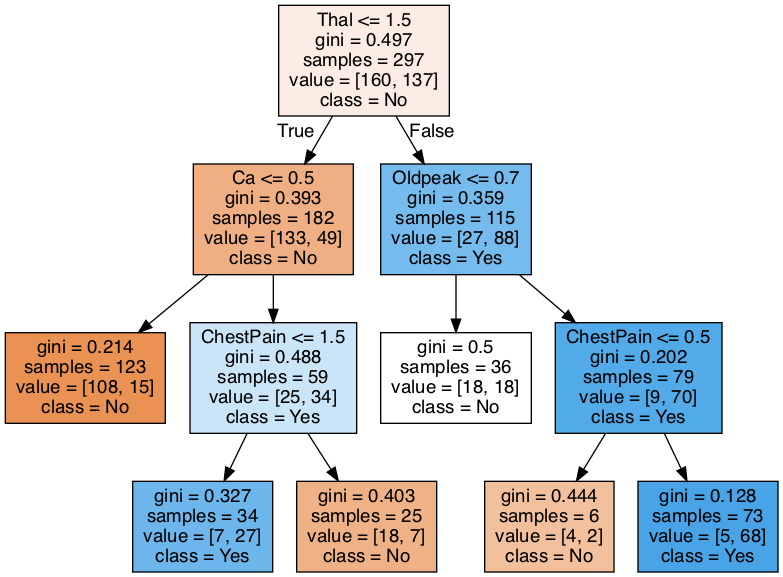

In [17]:
Image(graph2.create_png())

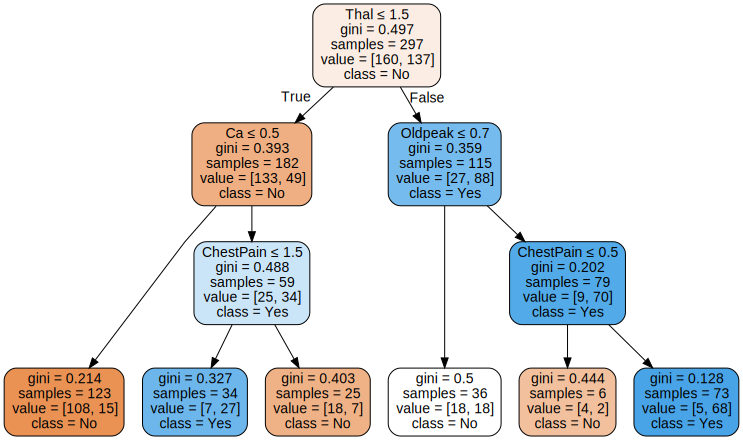

In [18]:
# Flattened - using 'graphviz'

dot_data = tree.export_graphviz(clf
                    , out_file=None  # out_file=image_path("iris_tree.dot")
                    , feature_names= X2.columns 
                    , class_names= ['No', 'Yes']  
                    , filled=True, rounded=True  
                    , special_characters=True
                    , label='all' # 'root'
                    , leaves_parallel=True)  
graph = graphviz.Source(dot_data)  
graph 


In [ ]:
# Unpruned tree with minimum 5 samples in any leaf node

clf_u = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
clf_u.fit(X2,y2)

In [ ]:
graph_u, = print_tree(clf_u, features=X2.columns, class_names= ['No', 'Yes'])
Image(graph_u.create_png())

In [ ]:
# Pruning with CV

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42)

clf2 = DecisionTreeClassifier(random_state=42)
path2 = clf2.cost_complexity_pruning_path(X2_train, y2_train)
ccp_alphas2, impurities2 = path2.ccp_alphas, path2.impurities

In [ ]:
# fitting trees for each alpha
sm_ccp2 = ccp_alphas2 #[:15] #range(1,25)
sm_cv_scores_mean2, sm_cv_scores_std2, sm_scores2 = run_cv_on_trees(X2_train, y2_train, sm_ccp2, cv=10, scoring=None, treetype='classifier')

In [ ]:
# plotting score (MSE or Accuracy)
plot_cv_on_trees(sm_ccp2, sm_cv_scores_mean2, sm_cv_scores_std2, sm_scores2, 'Score per ccp (alpha) on training data')

#### Print the best alpha - note score here is accuracy, so we are looking at a **maximum**

In [ ]:
idx_best = sm_cv_scores_mean2.argmax() # Use argmax() here, not argmin()
best_alpha = sm_ccp2[idx_best]
sm_best_tree_cv_score = sm_cv_scores_mean2[idx_best]
sm_best_tree_cv_score_std = sm_cv_scores_std2[idx_best]
print('The tree with alpha={} at step={} achieves the best mean cross-validation score {} +/- {} on training dataset'.format(
      round(best_alpha,7), idx_best, round(sm_best_tree_cv_score, 5), round(sm_best_tree_cv_score_std, 5)))

## Lab

### 8.3.1 Fitting Classification Trees

Data exported from package 'ISLR' (in R) to a csv file. Load it:

In [30]:
df3 = pd.read_csv('/Users/daniel421/Desktop/STAT_724/ISLR_data/Carseats.csv').drop('Unnamed: 0', axis=1)
df3.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


Create a label with values 0 or 1.

In [31]:
df3['High'] = df3.Sales.map(lambda x: 1 if x>8 else 0)
df3.ShelveLoc = pd.factorize(df3.ShelveLoc)[0]

df3.Urban = df3.Urban.map({'No':0, 'Yes':1})
df3.US = df3.US.map({'No':0, 'Yes':1})
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    int64  
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    int64  
 10  US           400 non-null    int64  
 11  High         400 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 37.6 KB


In [32]:
df3.head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,0,42,17,1,1,1
1,11.22,111,48,16,260,83,1,65,10,1,1,1
2,10.06,113,35,10,269,80,2,59,12,1,1,1
3,7.40,117,100,4,466,97,2,55,14,1,1,0
4,4.15,141,64,3,340,128,0,38,13,1,0,0


In [33]:
X = df3.drop(['Sales', 'High'], axis=1)
y = df3.High

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

### Set max_depth to 6

In [34]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6)

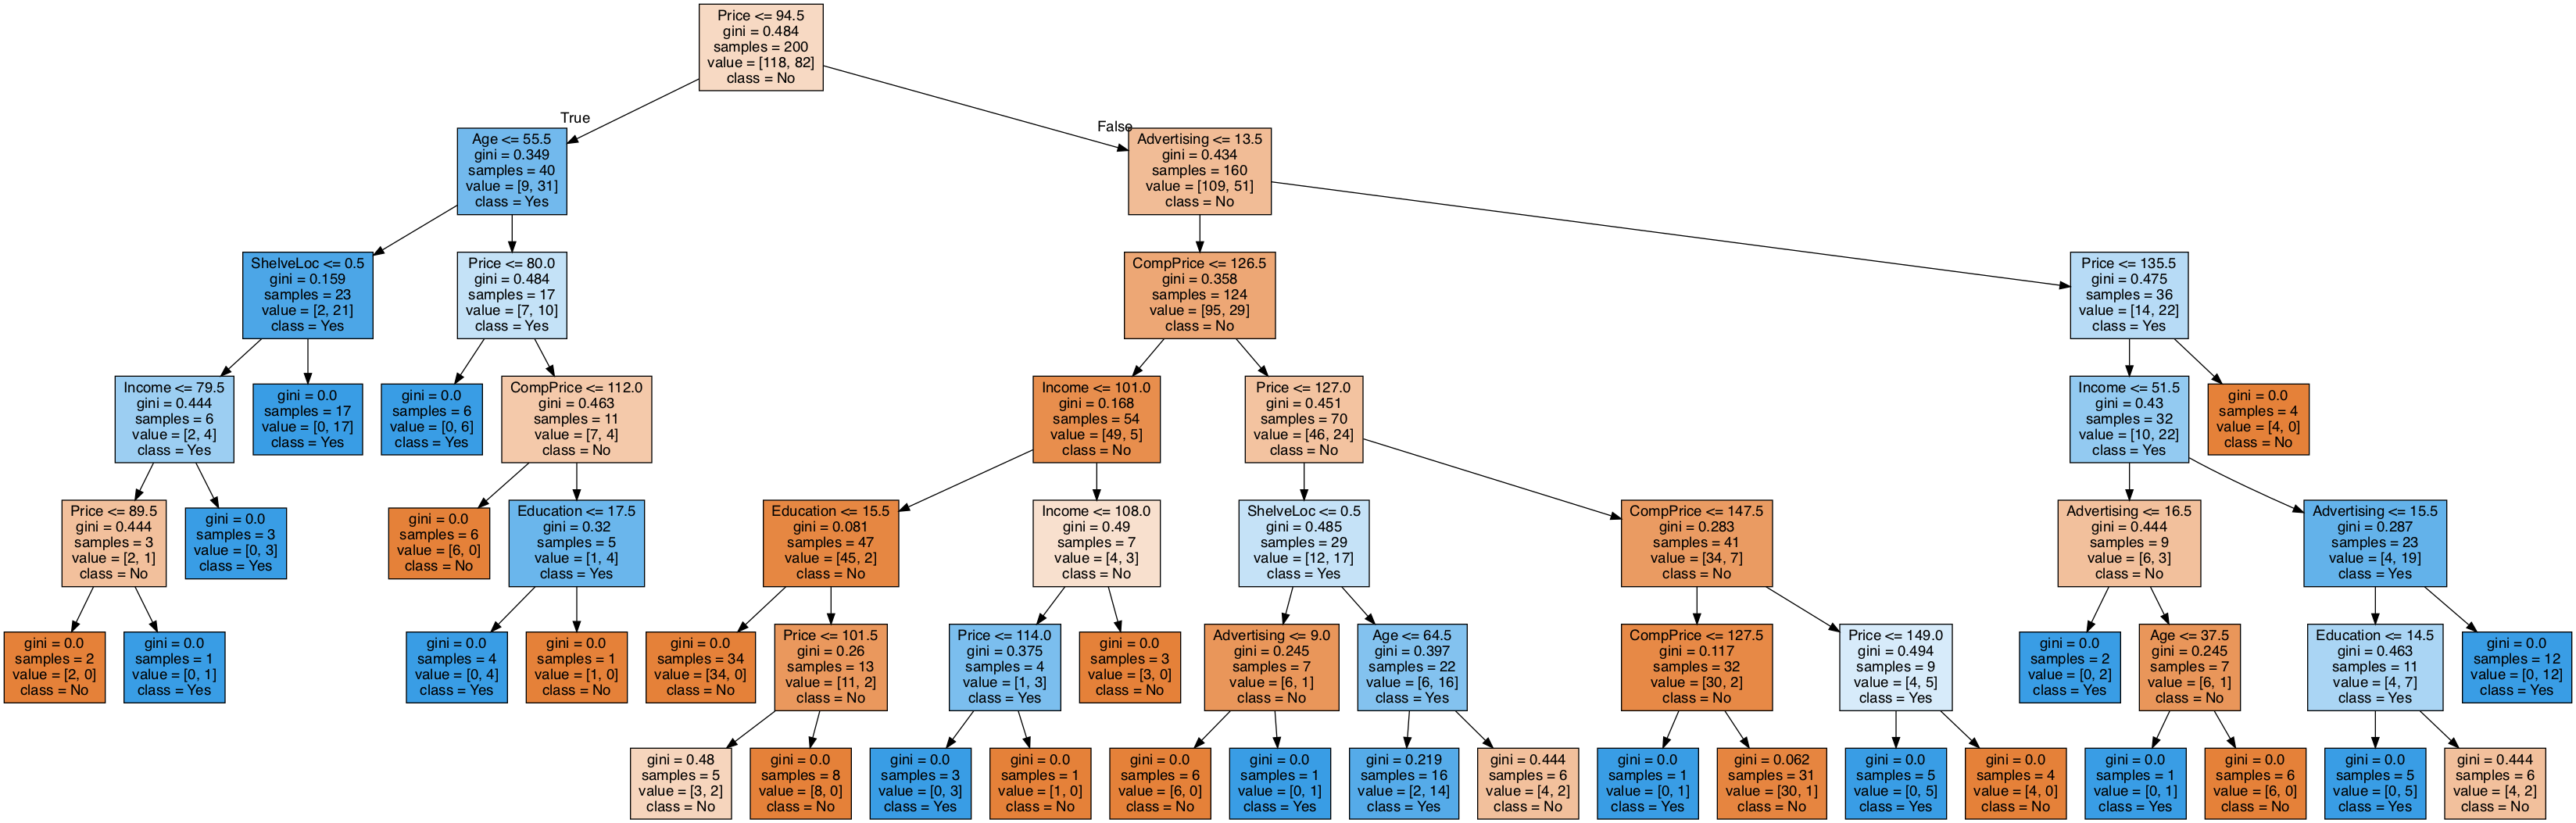

In [35]:
graph3, = print_tree(clf, features=X.columns, class_names=['No', 'Yes'])
Image(graph3.create_png())

In [36]:
pred_test = clf.predict(X_test)

print("accuracy: %0.3f" % accuracy_score(y_test, pred_test))

accuracy: 0.750


In [37]:
# Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, pred_test).T, index=['No', 'Yes'], columns=['No', 'Yes'])
cm.index.name = 'Predicted'
cm.columns.name = 'True'
cm

True,No,Yes
Predicted,,
No,100,32
Yes,18,50


In [38]:
# Precision of the model using test data is 72% in the large class
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80       118
           1       0.74      0.61      0.67        82

    accuracy                           0.75       200
   macro avg       0.75      0.73      0.73       200
weighted avg       0.75      0.75      0.75       200



Pruning implemented as above.

### 8.3.2 Fitting Regression Trees

Exported from R package 'MASS' to a csv file.

In [ ]:
boston_df = pd.read_csv('../data/Boston.csv')
boston_df.head()

In [ ]:
X = boston_df.drop('medv', axis=1)
y = boston_df.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

### Instead of pruning, choosing max depth 3

In [27]:
regr_b = DecisionTreeRegressor(max_depth=3, random_state=0)
regr_b.fit(X_train, y_train)
pred = regr_b.predict(X_test)


In [ ]:
graph, = print_tree(regr_b, features=X.columns)
Image(graph.create_png())

Another way to look at the predictiveness of the model is to plot predictions against actual values (on the test set)

In [ ]:
plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [ ]:
# One measure of success
mean_squared_error(y_test, pred)

In [ ]:
# Complete pruning as in 8.1.1 above

## <font color='blue'>Appendix</font>

### Use CV to select best CCP


Here, we pick the best CPP in terms of the best score (MSE for regression and accuracy for classifier) using the Cross-Validation (CV) approach. See:

https://scikit-learn.org/dev/modules/tree.html#complexity <br>
https://scikit-learn.org/dev/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py

In [ ]:
#DecisionTreeClassifier?
#DecisionTreeRegressor?

In [ ]:
### (a) The Hitters data again

In [ ]:
X = df_hit[['Years', 'Hits']].values
y = np.log(df_hit.Salary.values)     # Log-transform

In [ ]:
# Repeat the first step of prunning (see just before (a) above)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

regr2 = DecisionTreeRegressor(random_state=0)
path = regr2.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
# Function for fitting trees for diiferent values of the cost-complexity parameter (CCP) on the training data using cross-validation
def run_cv_on_trees(X, y, ccp_alphas, cv, scoring, treetype='classifier'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    scores = []
    
    i = 0
    for alpha in ccp_alphas:
        if treetype == 'classifier':
            tree_model = DecisionTreeClassifier(ccp_alpha=alpha)
            #scoring = 'accuracy' if scoring is None else scoring 
        else:
            tree_model = DecisionTreeRegressor(ccp_alpha=alpha)
            #scoring = 'mse' if scoring is None else scoring

        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        #if treetype=='regression':
        #    if i==0:
        #        cv_root = cv_scores 
        #    cv_scores = cv_scores/cv_root
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        scores.append(tree_model.fit(X, y).score(X, y))
        i+=1
        
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    scores = np.array(scores)
    return cv_scores_mean, cv_scores_std, scores

# function for plotting cross-validation results
def plot_cv_on_trees(ccp_alphas, cv_scores_mean, cv_scores_std, scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(ccp_alphas, cv_scores_mean, '-o', label='mean cross-validation score', alpha=0.9)
    ax.fill_between(ccp_alphas, cv_scores_mean-1*cv_scores_std, cv_scores_mean+1*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(ccp_alphas, scores, '-*', label='train score', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('CCP (alpha)', fontsize=14)
    ax.set_ylabel('Score', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(ccp_alphas)
    ax.legend()

In [ ]:
#cross_val_score?

In [ ]:
# fitting multiple trees for each alpha
sm_ccp = ccp_alphas #range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_scores = run_cv_on_trees(X_train, y_train, sm_ccp, cv=10, scoring=None, treetype='regression')

In [ ]:
# plotting score (MSE or Accuracy)
plot_cv_on_trees(sm_ccp, sm_cv_scores_mean, sm_cv_scores_std, sm_scores, 'Score per ccp (alpha) on training data')

In [ ]:
#ccp_alphas.shape
#ccp_alphas[0:100][::-1]

The plots don't look very clear so let's zoom in the left side of the plot.

In [ ]:
# Zoom in 
sm_ccp = ccp_alphas[-15:] #range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_scores = run_cv_on_trees(X_train, y_train, sm_ccp, cv=10, scoring=None, treetype='regression')
plot_cv_on_trees(sm_ccp, sm_cv_scores_mean, sm_cv_scores_std, sm_scores, 'Score per ccp (alpha) on training data')

This is a strange looking plot but let's pick the best CPP value anywаy.

In [ ]:
### Print the best alpha

In [ ]:
idx_best = sm_cv_scores_mean.argmin()
best_alpha = sm_ccp[idx_best]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_best]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_best]
print('The tree with alpha={} at step={} achieves the best mean cross-validation score {} +/- {} on training dataset'.format(
      round(best_alpha,7), idx_best, round(sm_best_tree_cv_score, 5), round(sm_best_tree_cv_score_std, 5)))

In [ ]:
### Display the best tree but first have some fun by choosing an (almost) unpruned tree

In [ ]:
best_regr = DecisionTreeRegressor(ccp_alpha=ccp_alphas[1]).fit(X_train, y_train)
graph, = print_tree(best_regr, features = ['Years', 'Hits'] ) 
Image(graph.create_png())

In [ ]:
### The best pruned tree is a "stump" ()
idx_best = sm_cv_scores_mean.argmin()
best_alpha = sm_ccp[idx_best-1] #sm_ccp[idx_best]
best_alpha

best_regr = DecisionTreeRegressor(ccp_alpha=best_alpha).fit(X_train, y_train)
graph, = print_tree(best_regr, features = ['Years', 'Hits'] ) 
Image(graph.create_png())

In [ ]:
idx_best = sm_cv_scores_mean.argmin()
best_alpha = sm_ccp[idx_best-1] #sm_ccp[idx_best]
best_alpha